<a href="https://colab.research.google.com/github/serjisa/transcriptomics.msu/blob/main/%D0%A1%D0%B5%D0%BC%D0%B8%D0%BD%D0%B0%D1%80%D1%8B/12_%D0%9A%D0%BB%D0%B0%D1%81%D1%82%D0%B5%D1%80%D0%B8%D0%B7%D0%B0%D1%86%D0%B8%D1%8F_%D0%B8_%D0%B5%D1%91_%D1%81%D1%82%D0%B0%D0%B1%D0%B8%D0%BB%D1%8C%D0%BD%D0%BE%D1%81%D1%82%D1%8C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Семинар 12. Кластеризация и дифференциальная экспрессия


In [ ]:
!pip3 install scanpy[leiden] anndata2ri scikit-misc scvi-tools opentsne harmonypy

# Необходимо, чтобы конкретно прогрузился matplotlib
import os
os.kill(os.getpid(), 9)

In [ ]:
import scanpy as sc

sc.set_figure_params(dpi=150)
sc.settings.verbosity = 3

adata = sc.datasets.pbmc3k()
adata.layers["counts"] = adata.X.copy()

try downloading from url
http://falexwolf.de/data/pbmc3k_raw.h5ad
... this may take a while but only happens once


  0%|          | 0.00/5.58M [00:00<?, ?B/s]

## Методы кластеризации scRNA-Seq

В основном для кластеризации scRNA-Seq используют графовые подходы типа Leiden, стандартный пайплайн выглядит следующим образом. (*Теперь для разнообразия давайте проведём контроль дисперсии в датасете при помощи Pearson residuals.*)

In [ ]:
sc.experimental.pp.highly_variable_genes(adata, n_top_genes=3000)
sc.experimental.pp.normalize_pearson_residuals_pca(adata)

extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'highly_variable_nbatches', int vector (adata.var)
    'highly_variable_intersection', boolean vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'residual_variances', float vector (adata.var)
computing analytic Pearson residuals on adata.X
    finished (0:00:00)
computing PCA
    with n_comps=50
    finished (0:00:02)


In [ ]:
sc.pp.neighbors(adata, n_neighbors=20, n_pcs=15)

computing neighbors
    using 'X_pca' with n_pcs = 15
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:18)


In [ ]:
# Для отрисовки
import openTSNE 

sc.tl.umap(adata)
adata.obsm["X_tsne"] = openTSNE.TSNE().fit(adata.obsm["X_pca"][:, :15])

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:11)


In [ ]:
# Для отрисовки и дифференциальной экспрессии
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

normalizing counts per cell
    finished (0:00:00)


Непосредственно кластеризация производится одной командой:

In [ ]:
sc.tl.leiden(adata, resolution=1)

running Leiden clustering
    finished: found 15 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


/usr/local/lib/python3.8/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


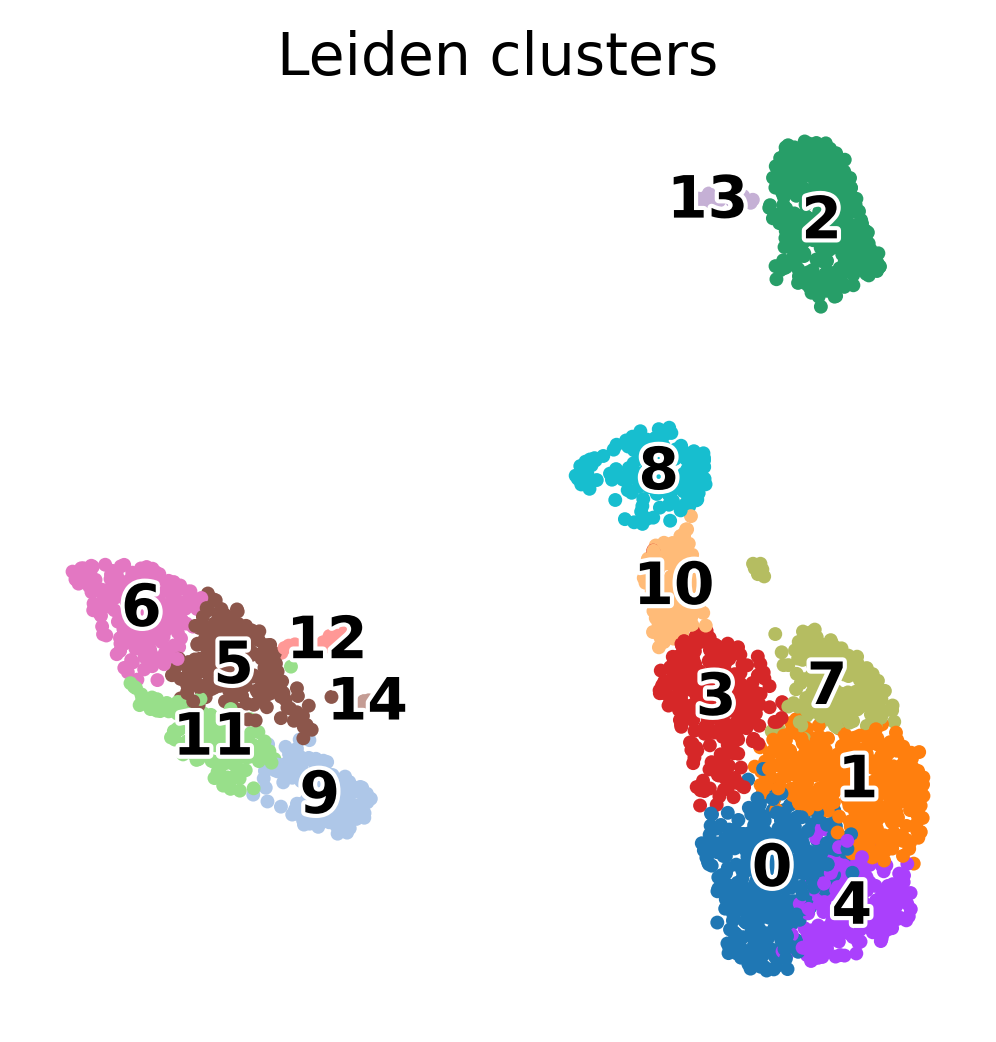

In [ ]:
sc.pl.umap(adata, color="leiden", frameon=False, title="Leiden clusters", legend_loc="on data", legend_fontoutline=2)

### Задание

Попробуйте поменять значение параметра `resolution` при кластеризации. Что поменялось?

In [ ]:
for resolution in [0.2, 0.5, 1, 2]:
  sc.tl.leiden(adata, resolution=resolution, key_added=f"leiden_{resolution}")

running Leiden clustering
    finished: found 5 clusters and added
    'leiden_0.2', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clustering
    finished: found 10 clusters and added
    'leiden_0.5', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clustering
    finished: found 15 clusters and added
    'leiden_1', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clustering
    finished: found 22 clusters and added
    'leiden_2', the cluster labels (adata.obs, categorical) (0:00:00)


/usr/local/lib/python3.8/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


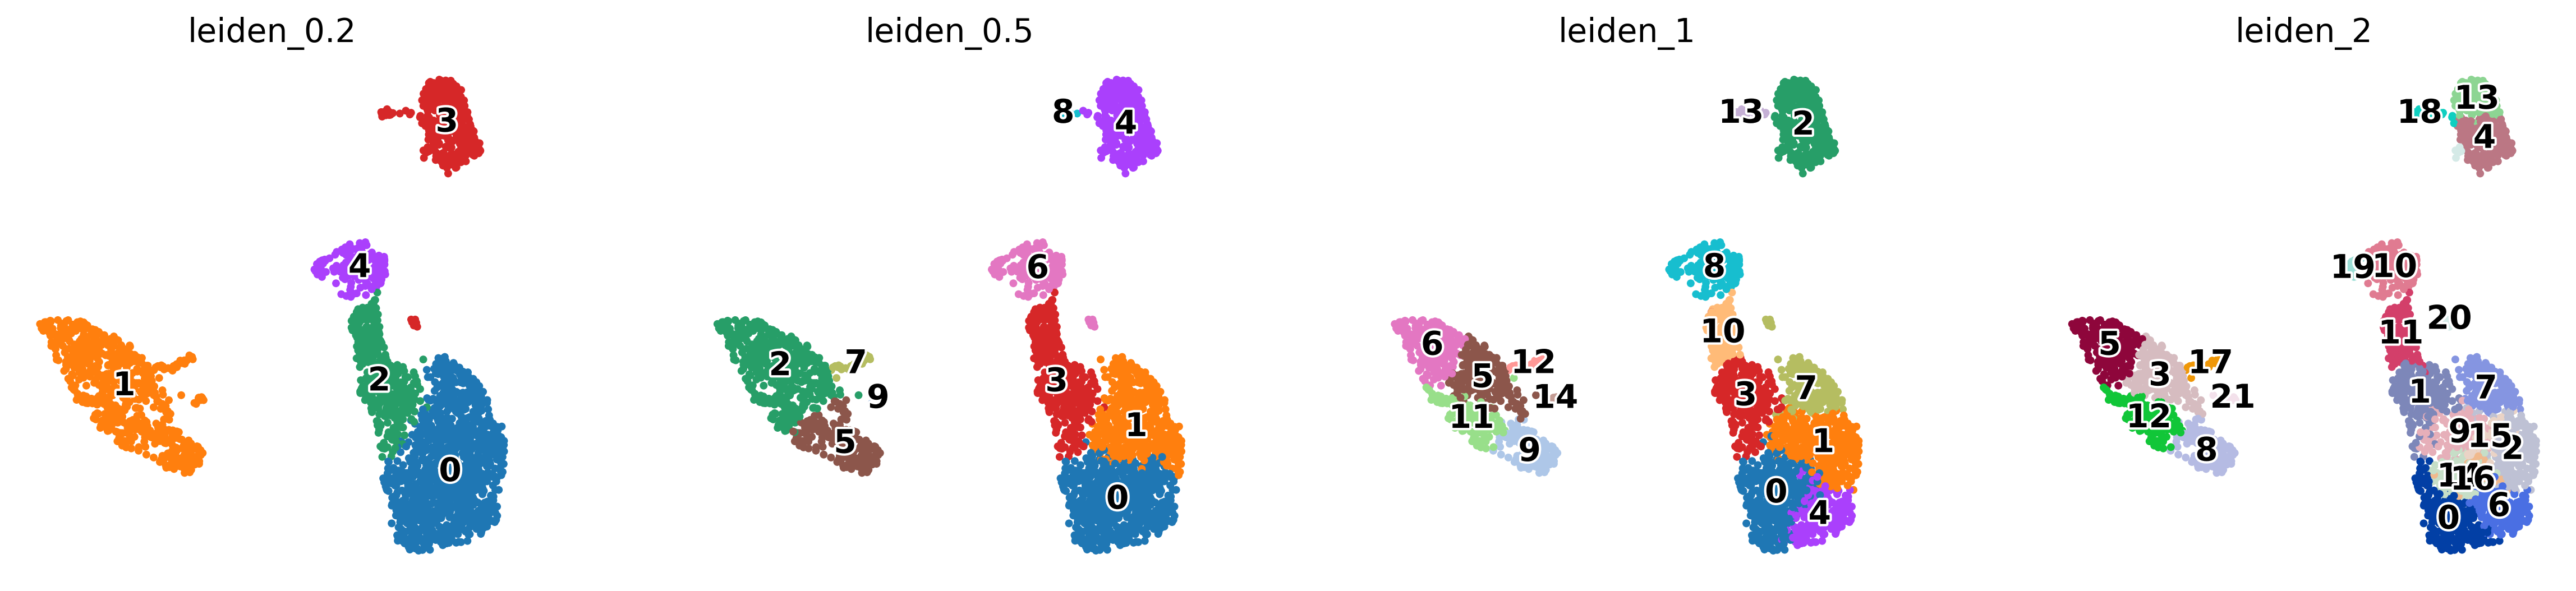

In [ ]:
cluster_keys = [f"leiden_{resolution}" for resolution in [0.2, 0.5, 1, 2]]
sc.pl.umap(
    adata,
    color=cluster_keys,
    frameon=False,
    legend_loc="on data",
    legend_fontoutline=2,
)

### Связи между кластерами

Часто нам бывает интересно не просто определить кластера, но и понять иерархическую связь между ними.

Storing dendrogram info using `.uns['dendrogram_leiden_1']`


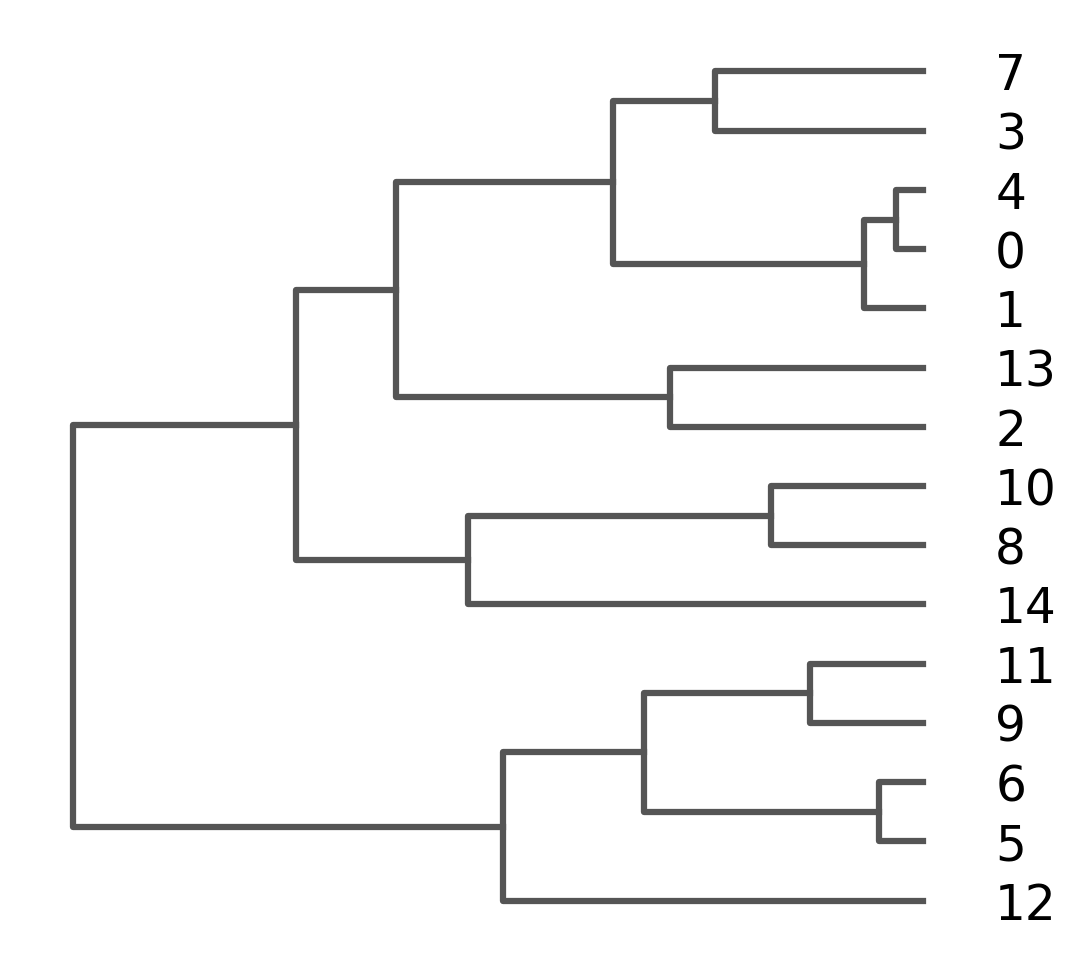

<AxesSubplot: >

In [ ]:
sc.tl.dendrogram(adata, groupby="leiden_1", n_pcs=15, use_rep="X_pca")
sc.pl.dendrogram(adata, groupby="leiden_1", orientation="left")

Storing dendrogram info using `.uns['dendrogram_leiden_1']`


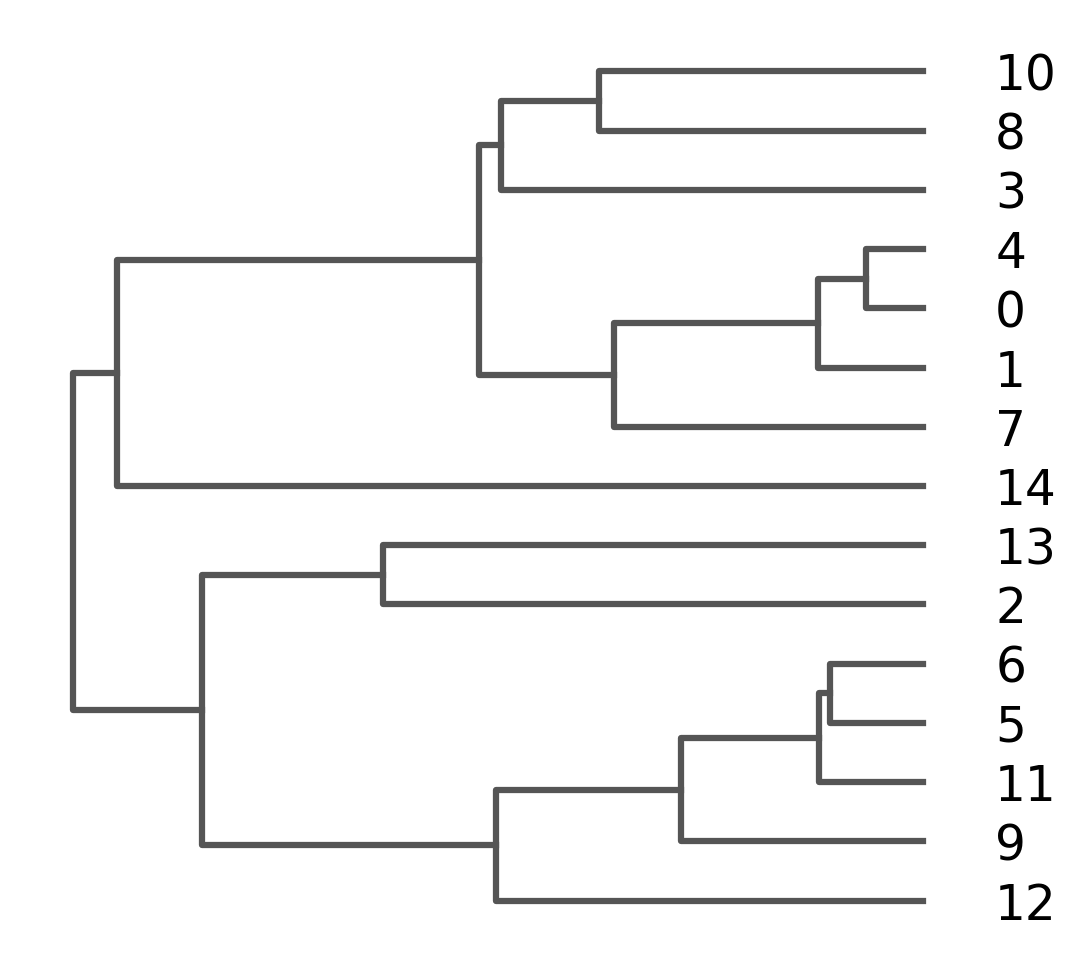

<AxesSubplot: >

In [ ]:
sc.tl.dendrogram(adata, groupby="leiden_1", n_pcs=15, use_rep="X_pca", linkage_method="single")
sc.pl.dendrogram(adata, groupby="leiden_1", orientation="left")

В случае с интегрированным датасетом кластеризацию обычно проводят на низкоразмерном представлении этого интегрированного датасета (например, на `X_pca_harmony`).

## K-Means

/usr/local/lib/python3.8/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


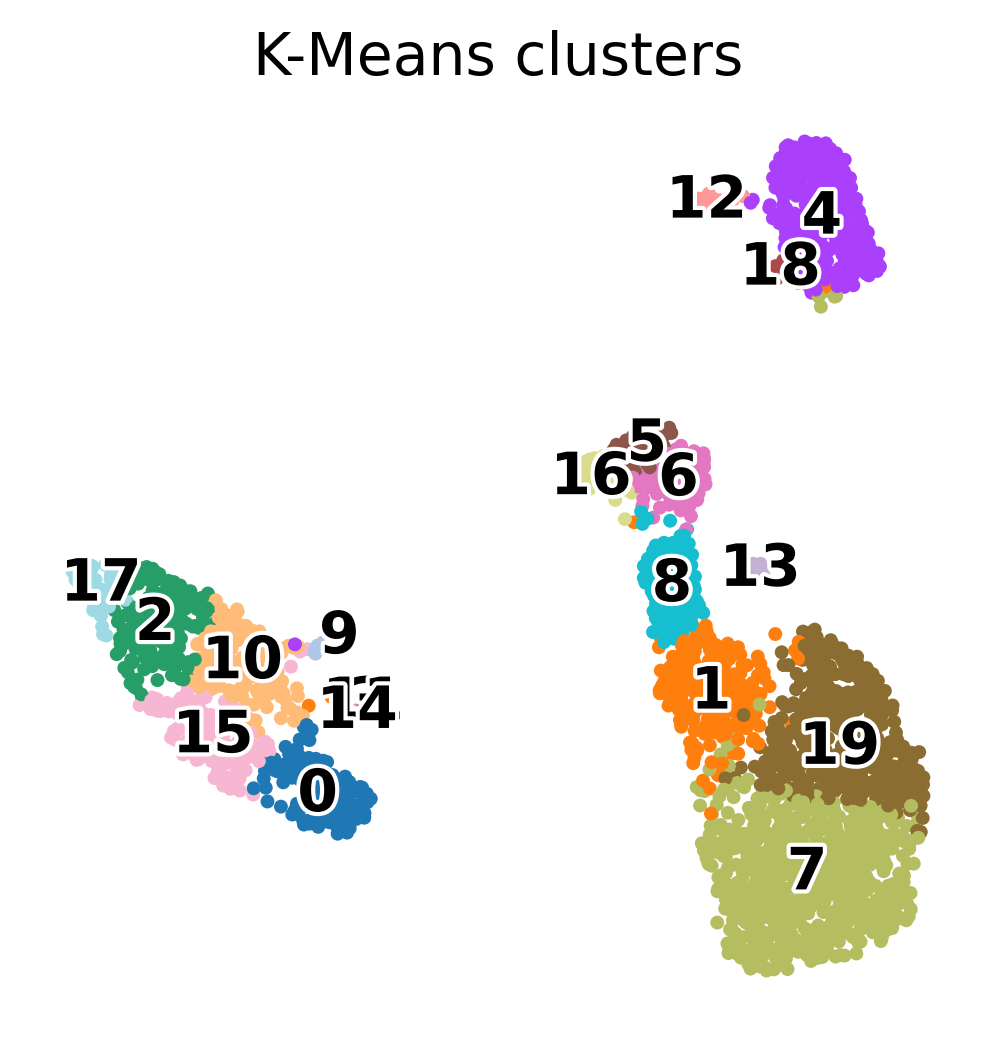

In [ ]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=20).fit(adata.obsm["X_pca"][:, :15])
adata.obs["K_Means"] = kmeans.labels_.astype(str)
sc.pl.umap(
    adata,
    color="K_Means",
    frameon=False,
    title="K-Means clusters",
    legend_loc="on data",
    legend_fontoutline=2
)

## Дифференциальная экспрессия в scRNA-Seq

После того, как вы определили связи между кластерами, необходимо понять, что перед вами за кластера. Есть несколько стратегий для аннотации кластеров, но одной из важнейших задач во время этого процесса является определение дифференциально экспрессированных генов в кластерах.

### Дифференциальная экспрессия внутри одного батча

Для определения дифференциально экспрессированных генов в каком-то кластере чаще всего используют самые простые непараметрические тесты и сравнивают кластер со всем остальным окружением.

In [ ]:
sc.tl.rank_genes_groups(adata, groupby="leiden", method="wilcoxon")

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:06)


Теперь для того, чтобы получить таблицу с дифференциально экспрессированными генами, необходимо выполнить следующие команду:

In [ ]:
sc.get.rank_genes_groups_df(adata, group="13").head()

,names,scores,logfoldchanges,pvals,pvals_adj
0,IGLL5,8.445921,10.768857,3.016579e-17,9.875675e-13
1,CD79B,7.301545,4.457446,2.844821e-13,4.656687e-09
2,CD74,7.241578,3.581731,4.434952e-13,4.839715e-09
3,HLA-DRA,6.968700,4.285433,3.198828e-12,2.618080e-08
4,MS4A1,6.896766,4.648869,5.319984e-12,3.483313e-08


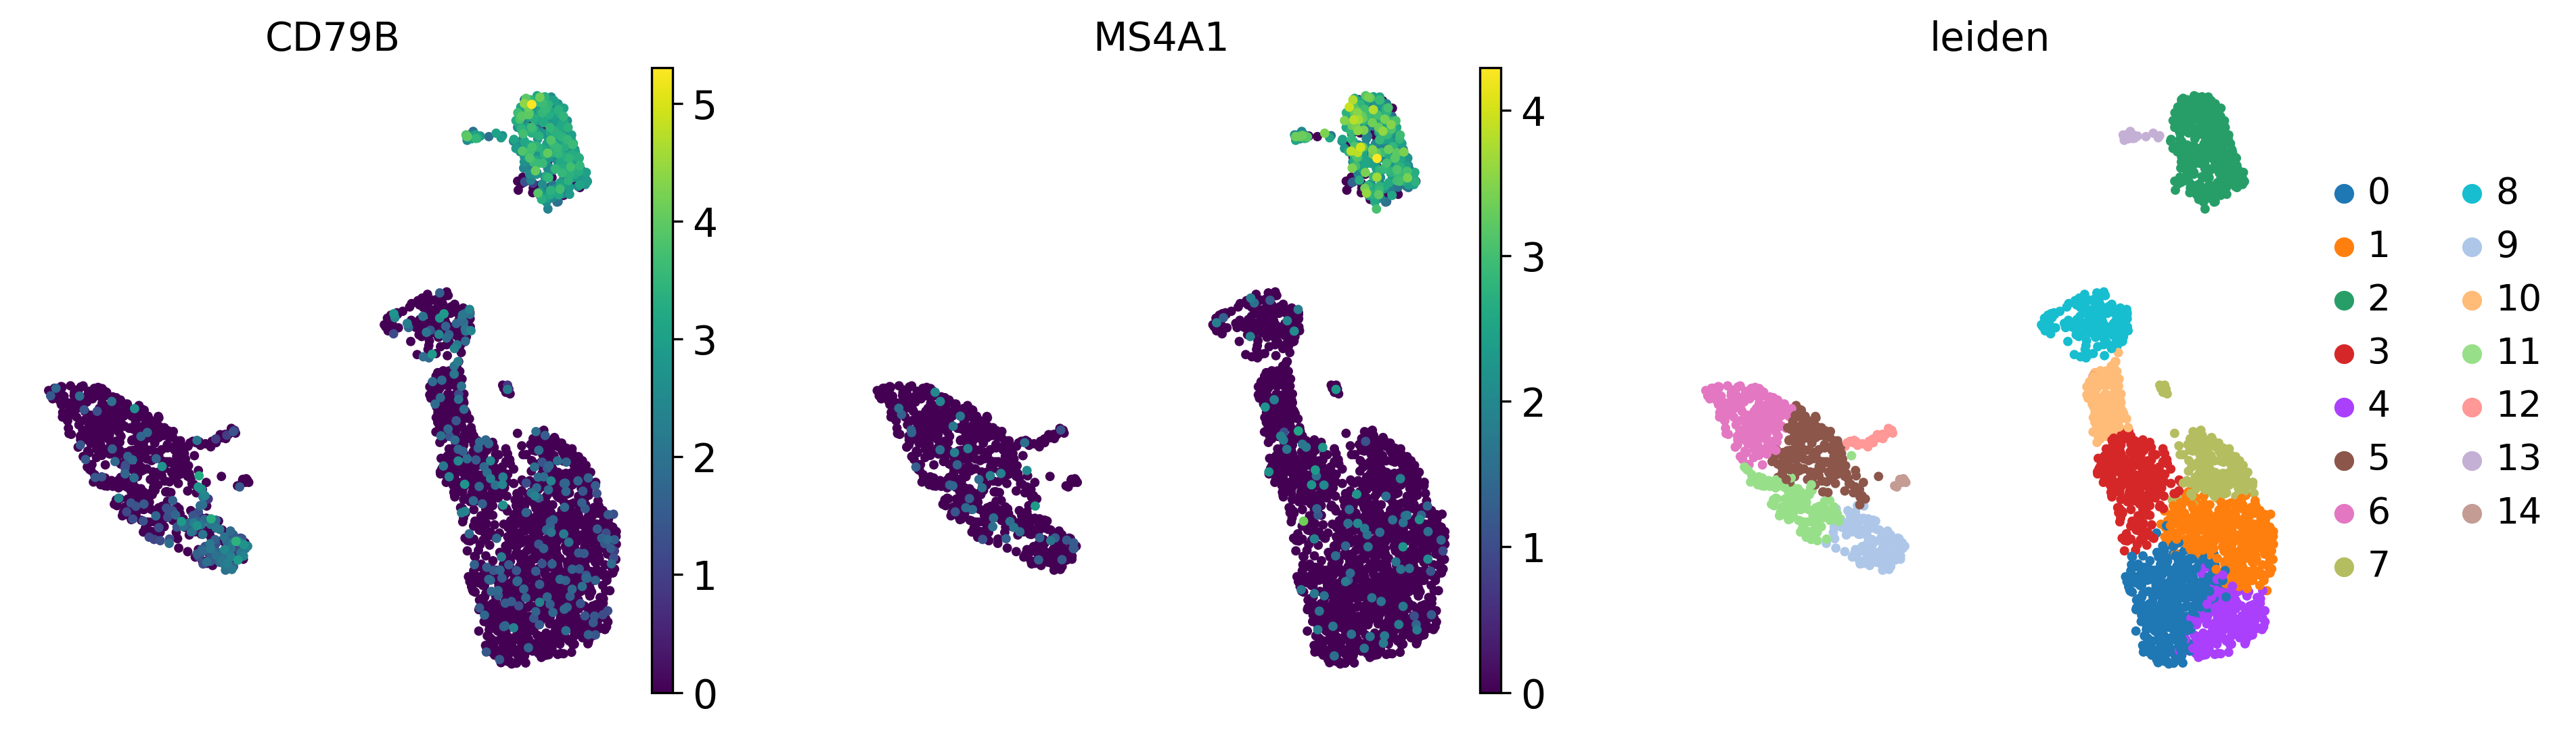

In [ ]:
sc.pl.umap(adata, color=["CD79B", "MS4A1", "leiden"], frameon=False)

In [ ]:
sc.tl.rank_genes_groups(adata, groupby="leiden", method="wilcoxon", groups=["0"], reference="4")
sc.get.rank_genes_groups_df(adata, group="0").head(30)

/usr/local/lib/python3.8/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


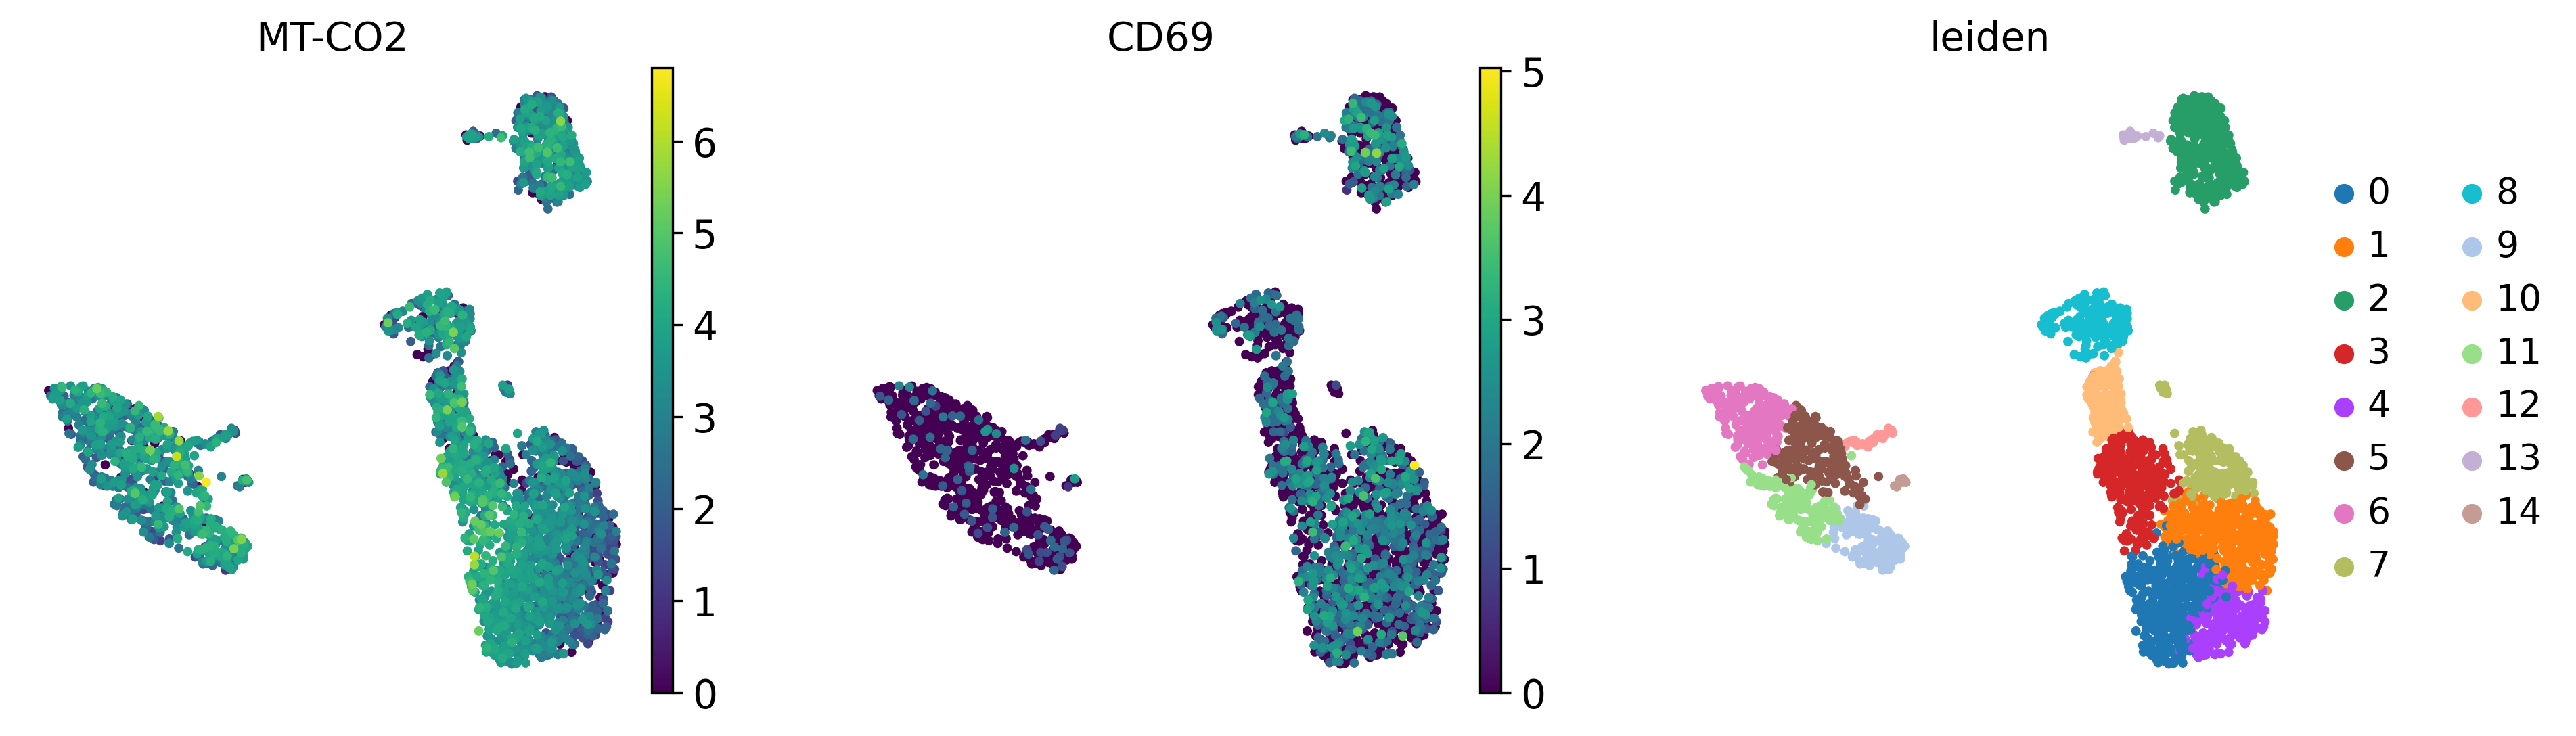

In [ ]:
sc.pl.umap(adata, color=["MT-CO2", "CD69", "leiden"], frameon=False)

#### Задание

Прочитайте описание функции `sc.tl.rank_genes_groups` и оцените дифференциальную экспрессию между кластерами **2** и **13**. Правда ли это два разных кластера?

In [ ]:
sc.tl.rank_genes_groups(adata, groupby="leiden", method="wilcoxon", groups=["13"], reference="2")
sc.get.rank_genes_groups_df(adata, group="13").head(10)

ranking genes
--> Few observations in a group for normal approximation (<=25). Lower test accuracy.
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:01)


,names,scores,logfoldchanges,pvals,pvals_adj
0,IGLL5,8.179294,7.925423,2.855118e-16,9.347085e-12
1,TMEM9B,2.594474,2.098842,9.473586e-03,1.000000e+00
2,BLK,2.402252,1.618657,1.629448e-02,1.000000e+00
3,EEF1A1,2.190289,0.182573,2.850331e-02,1.000000e+00
4,AP5M1,2.177820,3.795974,2.941943e-02,1.000000e+00
5,NUP88,2.124829,2.639384,3.360086e-02,1.000000e+00
6,TSTD1,2.100931,1.400860,3.564698e-02,1.000000e+00
7,TSC22D3,2.070799,0.939633,3.837755e-02,1.000000e+00
8,TPD52L2,2.038589,3.089628,4.149104e-02,1.000000e+00
9,CORO1A,1.924295,0.658567,5.431758e-02,1.000000e+00


In [ ]:
sc.get.rank_genes_groups_df(adata, group="13").tail(10)

,names,scores,logfoldchanges,pvals,pvals_adj
32728,ZFP36L2,-2.078073,-1.793020,0.037703,1.0
32729,RPS15A,-2.098853,-0.460405,0.035830,1.0
32730,RPS20,-2.114439,-0.532203,0.034478,1.0
32731,RPL36A,-2.143532,-0.629662,0.032070,1.0
32732,SH3BGRL,-2.152883,-1.459413,0.031328,1.0
32733,YBX1,-2.196523,-0.743008,0.028055,1.0
32734,RPL36AL,-2.527975,-1.377543,0.011472,1.0
32735,RPL31,-2.603825,-0.547404,0.009219,1.0
32736,RPL17,-2.616293,-0.539952,0.008889,1.0
32737,RPS24,-2.667206,-0.665007,0.007648,1.0


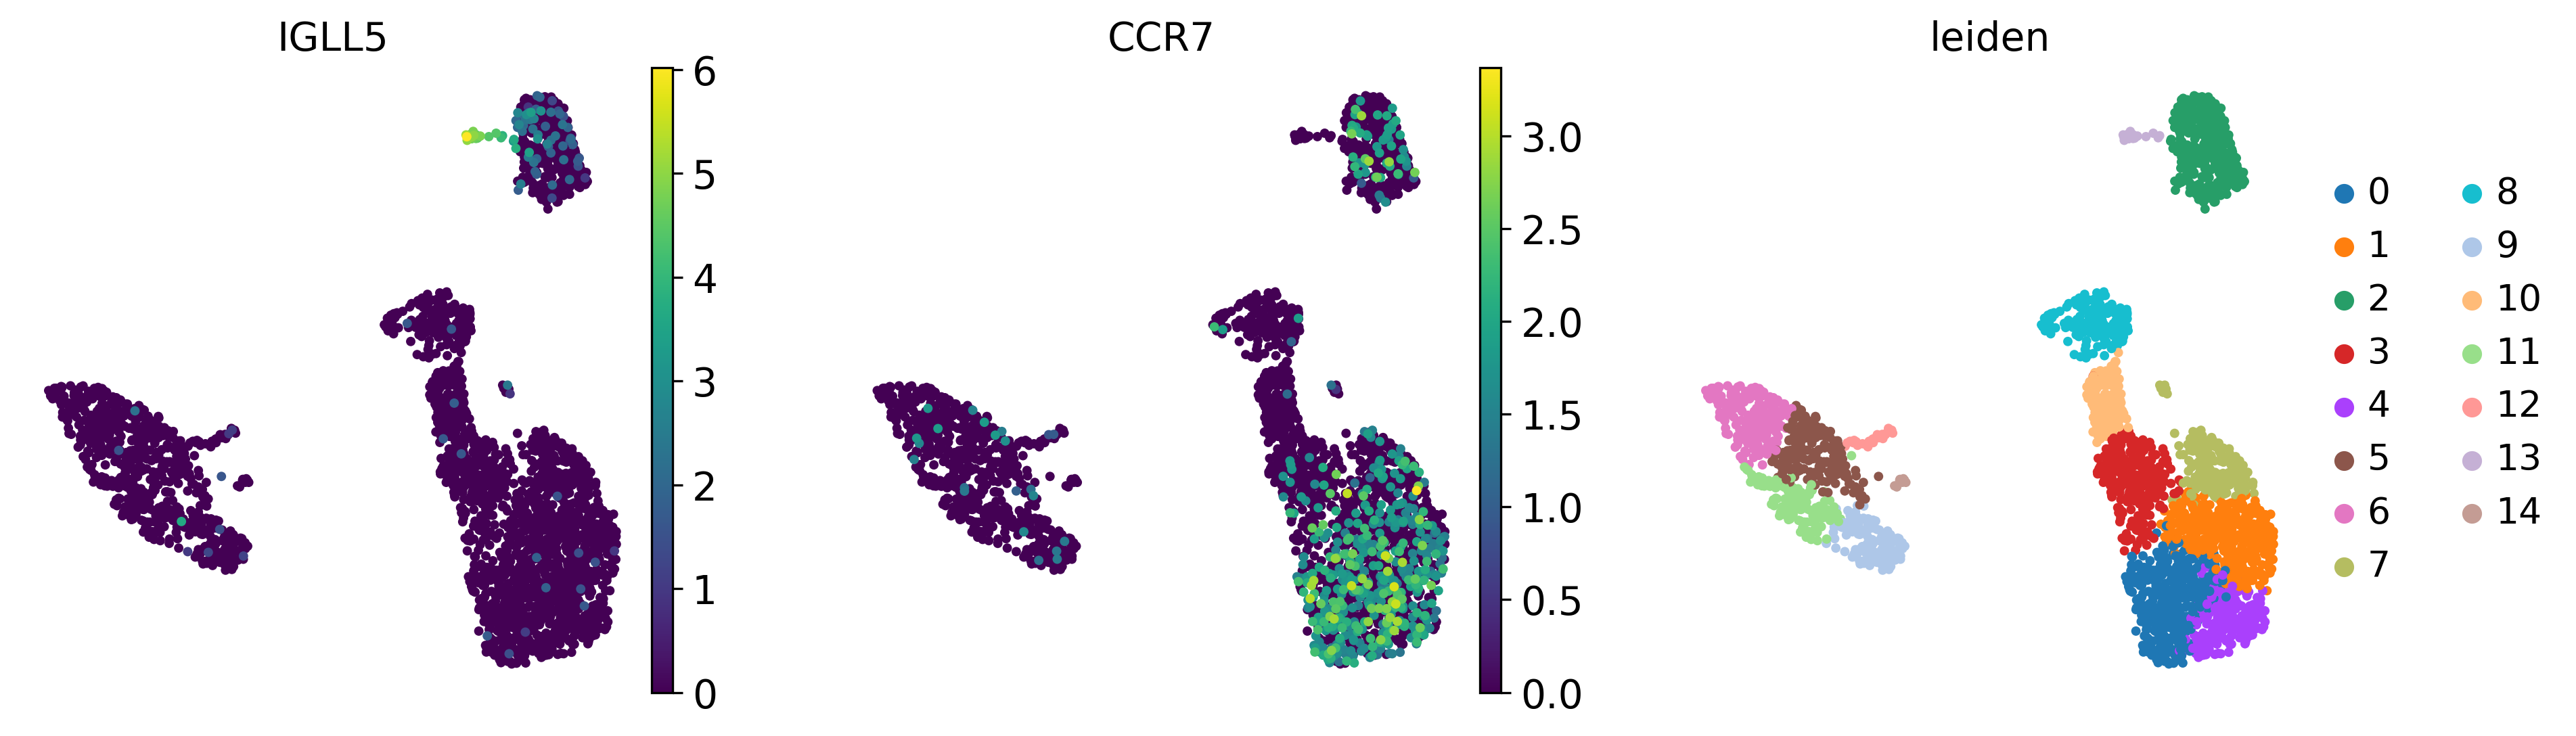

In [ ]:
sc.pl.umap(adata, color=["IGLL5", "CCR7", "leiden"], frameon=False)

### Дифференциальная экспрессия в большом датасете из нескольких батчей

Представим ситуацию, когда мы интегрировали датасет, после чего в одном кластере оказались клетки из нескольких батчей. Может произойти такое, что вы переинтегрировали данные, и на самом деле клетки внутри этого кластера обладают очень разными свойствами и маркерными генами.

Если вы проведёте классическую дифференциальную экспрессию в данном случае, то можете получить список генов от того батча, который просто дал больше клеток этому кластеру. Для того, чтобы бороться с этим, можно провести тест дифференциальной экспрессии для каждого батча индивидуально, после чего аггрегировать различные p-value вместе для того, чтобы определить итоговую значимость дифф. экспрессии.

In [ ]:
!gdown "1jW548g6ERFS0t7NywgyjRs6VaE5QwXbg&confirm=t"
adata_harmony = sc.read_h5ad("PBMC_Satija.h5ad")
adata_harmony.layers["counts"] = adata_harmony.X.copy()

Downloading...
From: https://drive.google.com/uc?id=1jW548g6ERFS0t7NywgyjRs6VaE5QwXbg&confirm=t
To: /content/PBMC_Satija.h5ad
100% 243M/243M [00:01<00:00, 133MB/s] 


In [ ]:
sc.pp.normalize_total(adata_harmony)
sc.pp.log1p(adata_harmony)

sc.pp.highly_variable_genes(
    adata_harmony,
    n_top_genes=3000,
    flavor="seurat_v3",
    layer="counts",
    batch_key="donor"
)

sc.pp.scale(adata_harmony)
sc.tl.pca(adata_harmony, n_comps=15)
sc.external.pp.harmony_integrate(adata_harmony, key="donor", max_iter_harmony=20)

sc.pp.neighbors(
    adata_harmony,
    use_rep="X_pca_harmony",
    n_pcs=15
)

sc.tl.leiden(adata_harmony)
sc.tl.umap(adata_harmony)

normalizing counts per cell
    finished (0:00:00)
If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
computing PCA
    on highly variable genes
    with n_comps=15
    finished (0:00:04)


2022-12-02 14:15:02,999 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...
2022-12-02 14:15:10,584 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2022-12-02 14:15:10,868 - harmonypy - INFO - Iteration 1 of 20
INFO:harmonypy:Iteration 1 of 20
2022-12-02 14:15:18,357 - harmonypy - INFO - Iteration 2 of 20
INFO:harmonypy:Iteration 2 of 20
2022-12-02 14:15:25,850 - harmonypy - INFO - Iteration 3 of 20
INFO:harmonypy:Iteration 3 of 20
2022-12-02 14:15:30,559 - harmonypy - INFO - Iteration 4 of 20
INFO:harmonypy:Iteration 4 of 20
2022-12-02 14:15:38,007 - harmonypy - INFO - Iteration 5 of 20
INFO:harmonypy:Iteration 5 of 20
2022-12-02 14:15:45,386 - harmonypy - INFO - Iteration 6 of 20
INFO:harmonypy:Iteration 6 of 20
2022-12-02 14:15:52,737 - harmonypy - INFO - Iteration 7 of 20
INFO:harmonypy:Iteration 7 of 20
2022-12-02 14:15:54,878 - 

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:24)
running Leiden clustering
    finished: found 18 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:03)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:28)


/usr/local/lib/python3.8/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


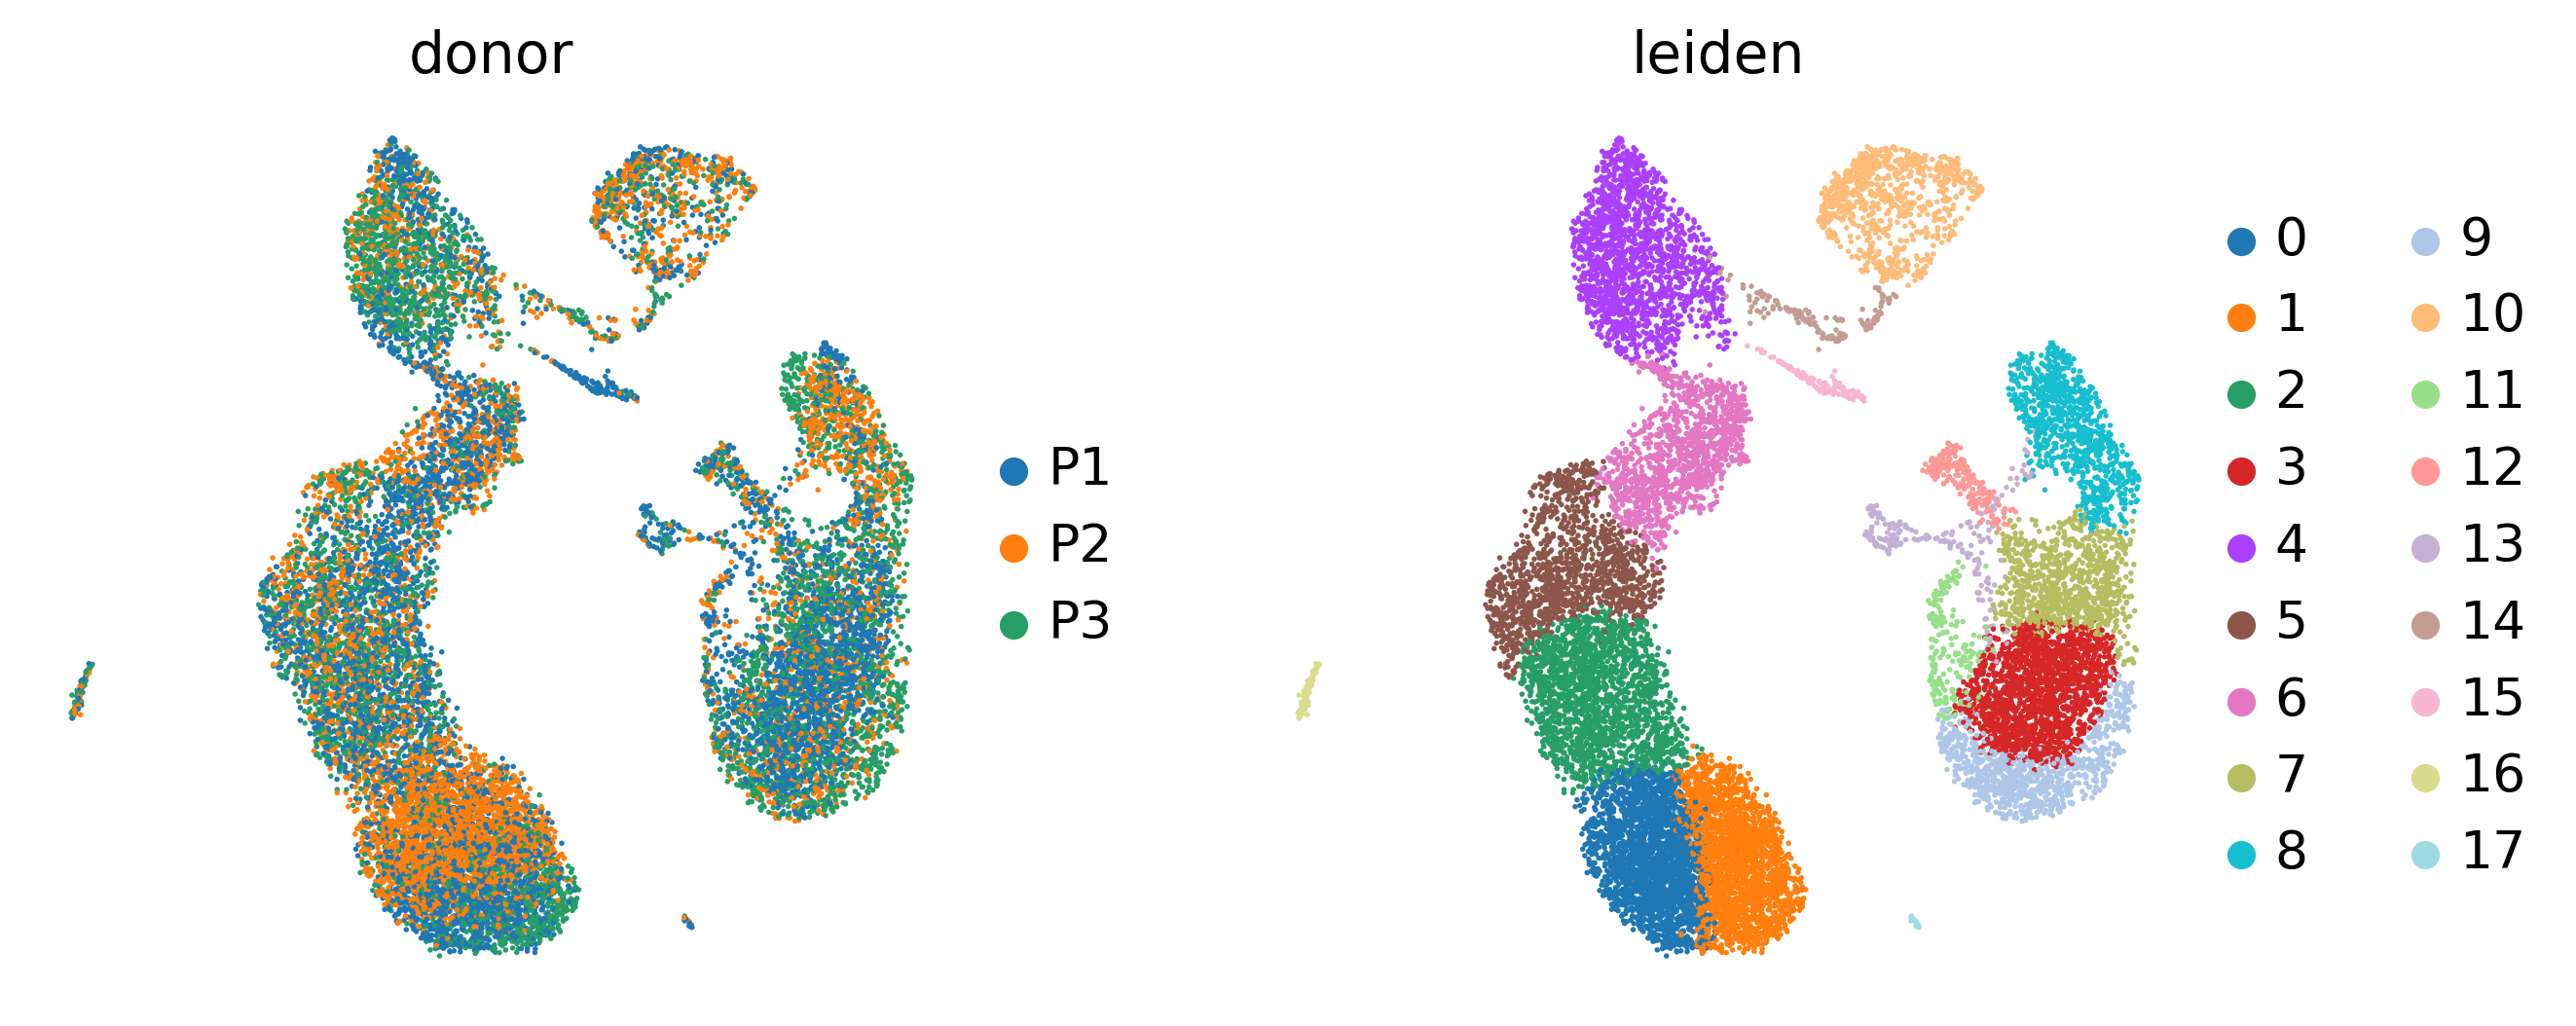

In [ ]:
sc.pl.umap(adata_harmony, color=["donor", "leiden"], frameon=False)

## Оценка стабильности кластеров

Достаточно важный шаг, который, однако, часто опускают при работе с данными scRNA-Seq &mdash; это оценка стабильности кластеров, которые у нас получаются после кластеризации.

### Сабсемплирование

Проверить стабильность кластера можно при помощи искуственного сабсемплирования. Восстановится ли кластер после того, как уберём N% клеток из датасета? Если да, то такой кластер мы назовём стабильным.

Давайте для начала напишем две вспомогательные функции &mdash; с пайплайном и для субсемплирования.

In [ ]:
def pipeline(adata, subsampled=False, resolution=1):
  adata_ = adata.copy()
  adata_.X = adata_.layers["counts"].copy()
  sc.pp.normalize_total(adata_)
  sc.pp.log1p(adata_)
  sc.pp.highly_variable_genes(adata_)
  sc.pp.scale(adata_)
  sc.tl.pca(adata_, n_comps=30)
  sc.pp.neighbors(adata_, n_neighbors=20)
  sc.tl.leiden(adata_, resolution=resolution)
  if not subsampled:
    sc.tl.umap(adata_)
  return adata_

def subsample(adata, pcts=70):
  from random import sample
  frac = pcts / 100
  return adata[sample(list(adata.obs_names), k=int(len(adata)*frac))]

In [ ]:
adata

AnnData object with n_obs × n_vars = 2700 × 32738
    obs: 'leiden', 'leiden_0.2', 'leiden_0.5', 'leiden_1', 'leiden_2', 'K_Means'
    var: 'gene_ids', 'means', 'variances', 'residual_variances', 'highly_variable_rank', 'highly_variable'
    uns: 'hvg', 'pca', 'pearson_residuals_normalization', 'log1p', 'neighbors', 'umap', 'leiden', 'leiden_colors', 'leiden_0.2_colors', 'leiden_0.5_colors', 'leiden_1_colors', 'leiden_2_colors', 'dendrogram_leiden_1', 'K_Means_colors', 'rank_genes_groups'
    obsm: 'X_pca', 'X_umap', 'X_tsne'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'distances', 'connectivities'

Теперь запустим их и посмотрим, что поменялось. Обратите внимание, что для удобства сравнения UMAP-координаты мы сохраняем из первого объекта.

normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
computing PCA
    on highly variable genes
    with n_comps=30
    finished (0:00:00)
computing neighbors
    using 'X_pca' with n_pcs = 30
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
running Leiden clustering
    finished: found 8 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:10)
normalizing counts per cell
    finished (0:00:00)
extracting highly va

/usr/local/lib/python3.8/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


<AxesSubplot: title={'center': 'Subsampled dataset'}, xlabel='UMAP1', ylabel='UMAP2'>

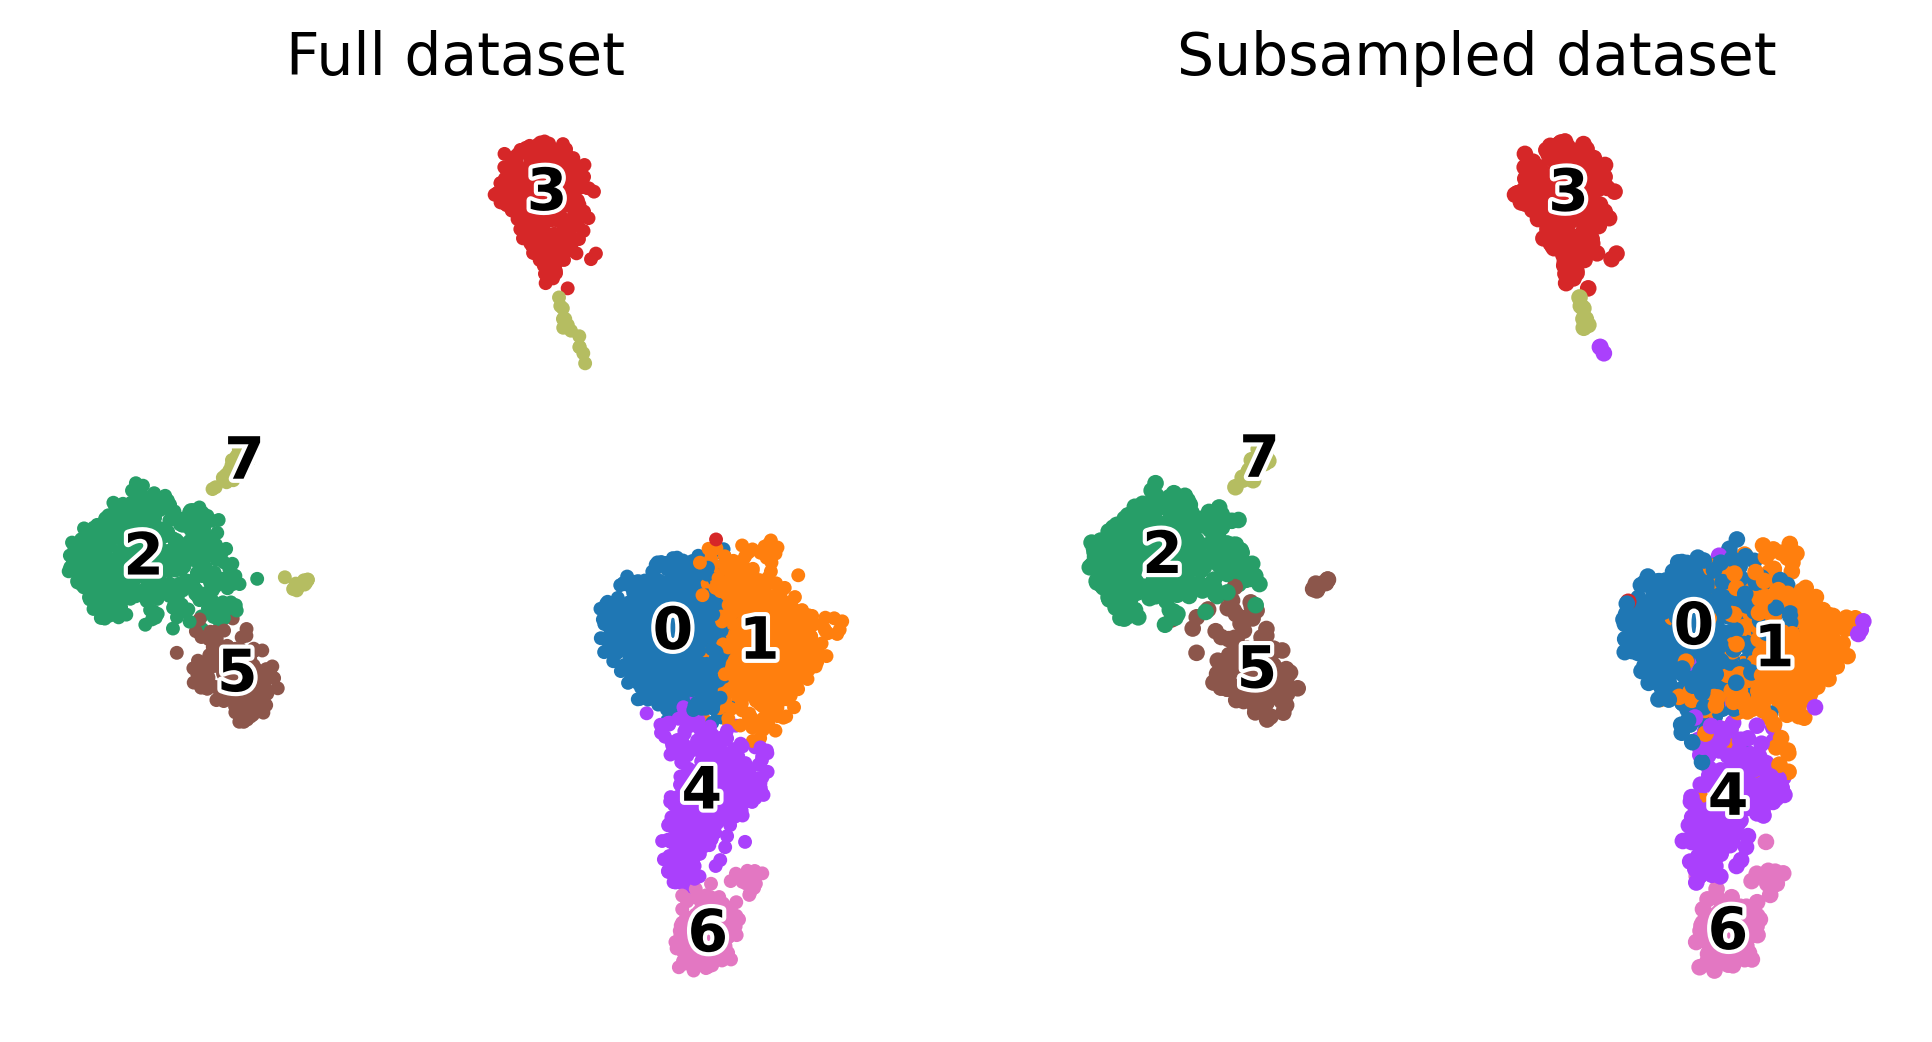

In [ ]:
adata_full = pipeline(adata)
adata_subsampled = pipeline(subsample(adata_full, pcts=70), subsampled=True)

import matplotlib.pyplot as plt
fig, axes = plt.subplots(ncols=2, figsize=(8, 4))

sc.pl.umap(adata_full, color="leiden", title="Full dataset", ax=axes[0], show=False, frameon=False,
           legend_loc="on data", legend_fontoutline=2)
sc.pl.umap(adata_subsampled, color="leiden", title="Subsampled dataset", ax=axes[1], frameon=False,
           show=False, legend_loc="on data", legend_fontoutline=2)

Теперь как сравнить кластеризации? Найдём confusion matrix между двумя кластеризациями, а потом для каждого из оригинальных кластеров найдём тот, который больше всего похож на него из второй кластеризации. Запомним для каждого кластера только самый похожий на него и метрику сходства.

<AxesSubplot: xlabel='leiden', ylabel='leiden'>

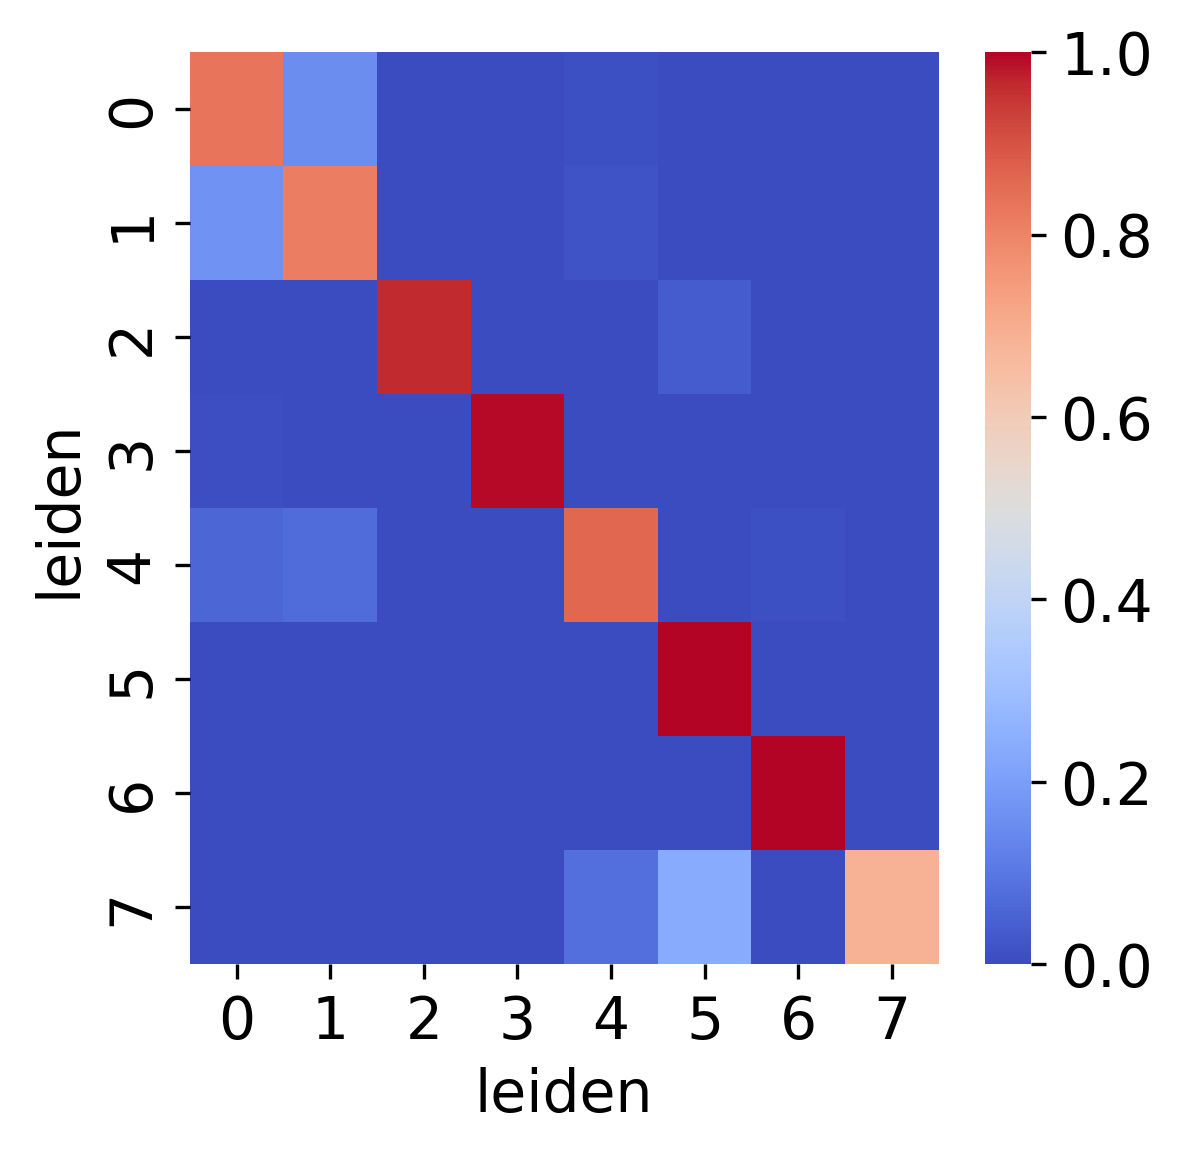

In [ ]:
import seaborn as sns
import numpy as np
import pandas as pd

conf_matrix = sc.metrics.confusion_matrix(
  adata_full[adata_subsampled.obs_names].obs.leiden,
  adata_subsampled.obs.leiden
)
sns.heatmap(conf_matrix, cmap="coolwarm")

Теперь повторим операции K раз и вычислим среднее для каждого из кластеров.

In [ ]:
for i in range(100):
  adata_subsampled = pipeline(subsample(adata_full, pcts=70), subsampled=True)
  conf_matrix = sc.metrics.confusion_matrix(
    adata_full[adata_subsampled.obs_names].obs.leiden,
    adata_subsampled.obs.leiden
  )
  if i == 0:
    results = pd.DataFrame(np.max(conf_matrix, axis=1), columns=[0])
  else:
    results[i] = np.max(conf_matrix, axis=1)

/usr/local/lib/python3.8/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


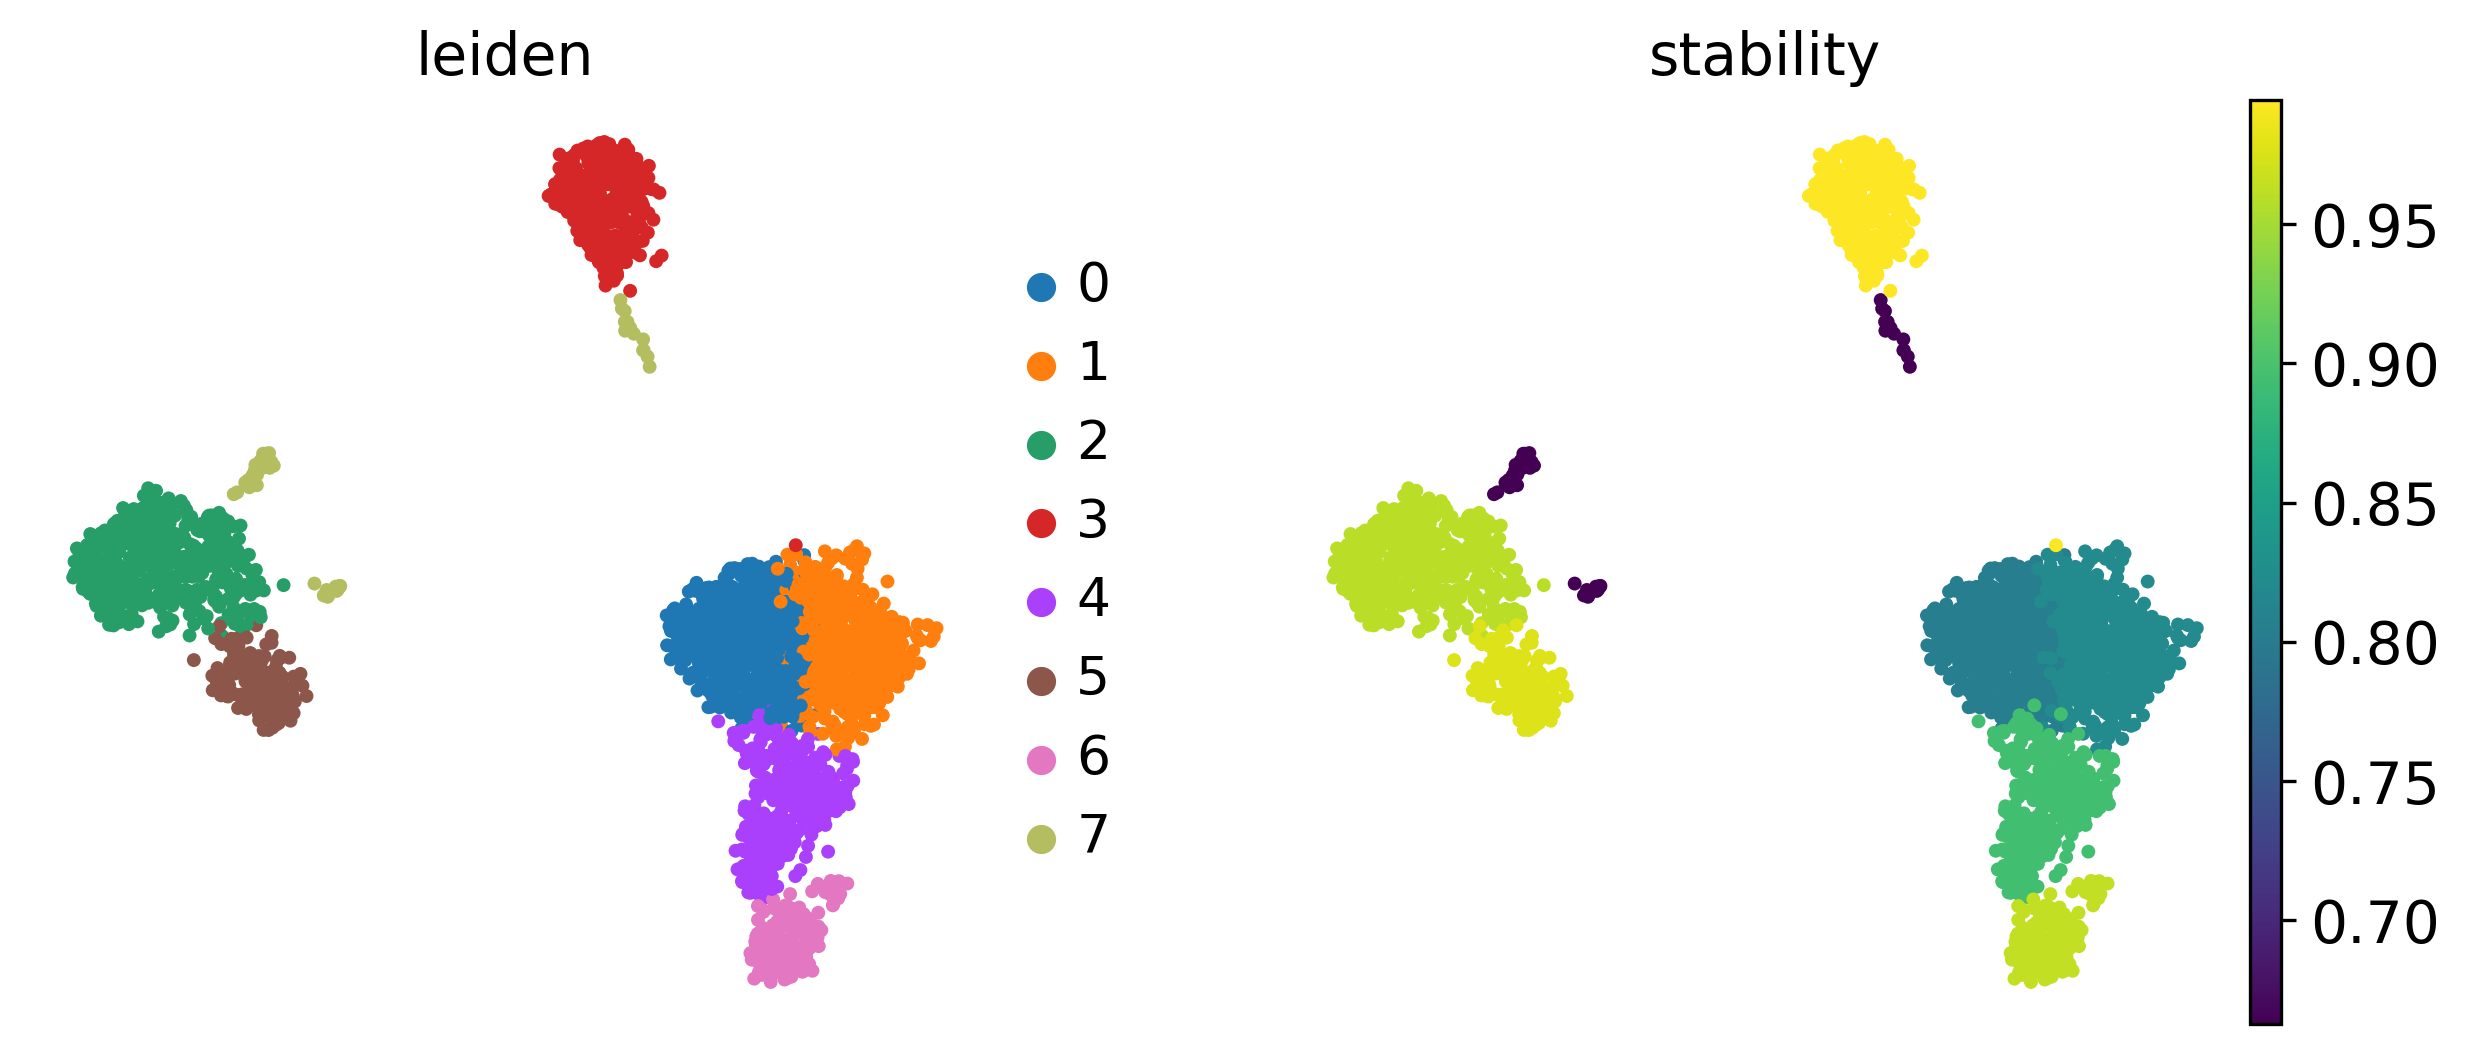

In [ ]:
adata_full.obs["stability"] = [dict(zip(np.mean(results, axis=1).index, list(np.mean(results, axis=1))))[i] for i in adata_full.obs.leiden]
sc.pl.umap(adata_full, color=["leiden", "stability"], frameon=False)

#### Задание

Попробуйте поменять следующие параметры: число соседей в kNN-графе, разрешение кластеризации, ... Стали ли кластера стабильнее? Поменялось ли число стабильных кластеров?

### Изменение `random_state` при кластеризации

Кроме сабсемплирование мы можем оценить стабильность кластера при помощи изменения другого параметра &mdash; `random_state` &mdash; при кластеризации.

#### Задание

Модифицируйте код выше так, чтобы он проверял стабильность не при сабсемплировании, а при изменении `random_state`.

In [ ]:
for i in range(100):
  adata_subsampled = adata_full.copy()
  sc.tl.leiden(adata_subsampled, random_state=i)
  conf_matrix = sc.metrics.confusion_matrix(
    adata_full.obs.leiden,
    adata_subsampled.obs.leiden
  )
  if i == 0:
    results = pd.DataFrame(np.max(conf_matrix, axis=1), columns=[0])
  else:
    results[i] = np.max(conf_matrix, axis=1)

### Как разобраться с похожими кластерами?

Посмотрим на кластера 0 и 1. На UMAP они выглядят очень похоже. Попытаемся разобраться, какие маркерные гены есть у этих кластеров друг по сравнению с другом:

In [ ]:
sc.tl.rank_genes_groups(adata_full, groupby="leiden", method="wilcoxon", groups=["0"], reference="1")
sc.get.rank_genes_groups_df(adata_full, group="0").head(20)

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:02)


/usr/local/lib/python3.8/dist-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(


,names,scores,logfoldchanges,pvals,pvals_adj
0,RPL32,11.983901,1.672740,4.315304e-33,4.709148e-29
1,RPS6,11.552433,1.308559,7.175978e-31,5.873179e-27
2,MALAT1,10.653799,1.751474,1.673904e-26,7.895796e-23
3,RPL13,10.604053,1.436459,2.853427e-26,1.167694e-22
4,RPS3A,10.200153,1.413807,1.979604e-24,7.200918e-21
5,RPL21,10.034034,1.262176,1.080115e-23,3.536080e-20
6,RPS12,9.758877,0.968004,1.690161e-22,4.256346e-19
7,RPL9,9.713283,1.161450,2.646726e-22,6.189181e-19
8,RPS27,9.222348,0.899273,2.906647e-20,4.595262e-17
9,RPS23,8.801130,1.303706,1.354454e-18,1.847588e-15


Мы видим, что в основном тут получаются гены рибосомальных белков. По всей видимости, перед нами искуственное разделение. Как с этим можно бороться? Можно попробовать удалить все гены, связанные с рибосомальными и митохондриальными белками. Они обладают высокой экспрессией, однакого никакого биологического смысла разница в них не несёт.

In [ ]:
import re

ribosomal_mask = re.compile("^RP[SL][0-9]*") # Задаём маску для генов рибосомальных белков
adata.var["ribo"] = [False if len(ribosomal_mask.findall(x)) == 0 else True for x in adata.var_names] # Находим все рибосомальные белки
adata.var["mt"] = adata.var_names.str.startswith("MT-")

adata_full = adata.copy()
adata_full = adata_full[:, ~adata_full.var.ribo] # Оставляем все гены, кроме генов рибосомальных белков
adata_full = adata_full[:, ~adata_full.var.mt] # Оставляем все гены, кроме генов, закодированных в митохондрии

Теперь посмотрим, получатся ли у нас те же кластера:

normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
computing PCA
    on highly variable genes
    with n_comps=30
    finished (0:00:01)
computing neighbors
    using 'X_pca' with n_pcs = 30
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
running Leiden clustering
    finished: found 9 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:10)


/usr/local/lib/python3.8/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


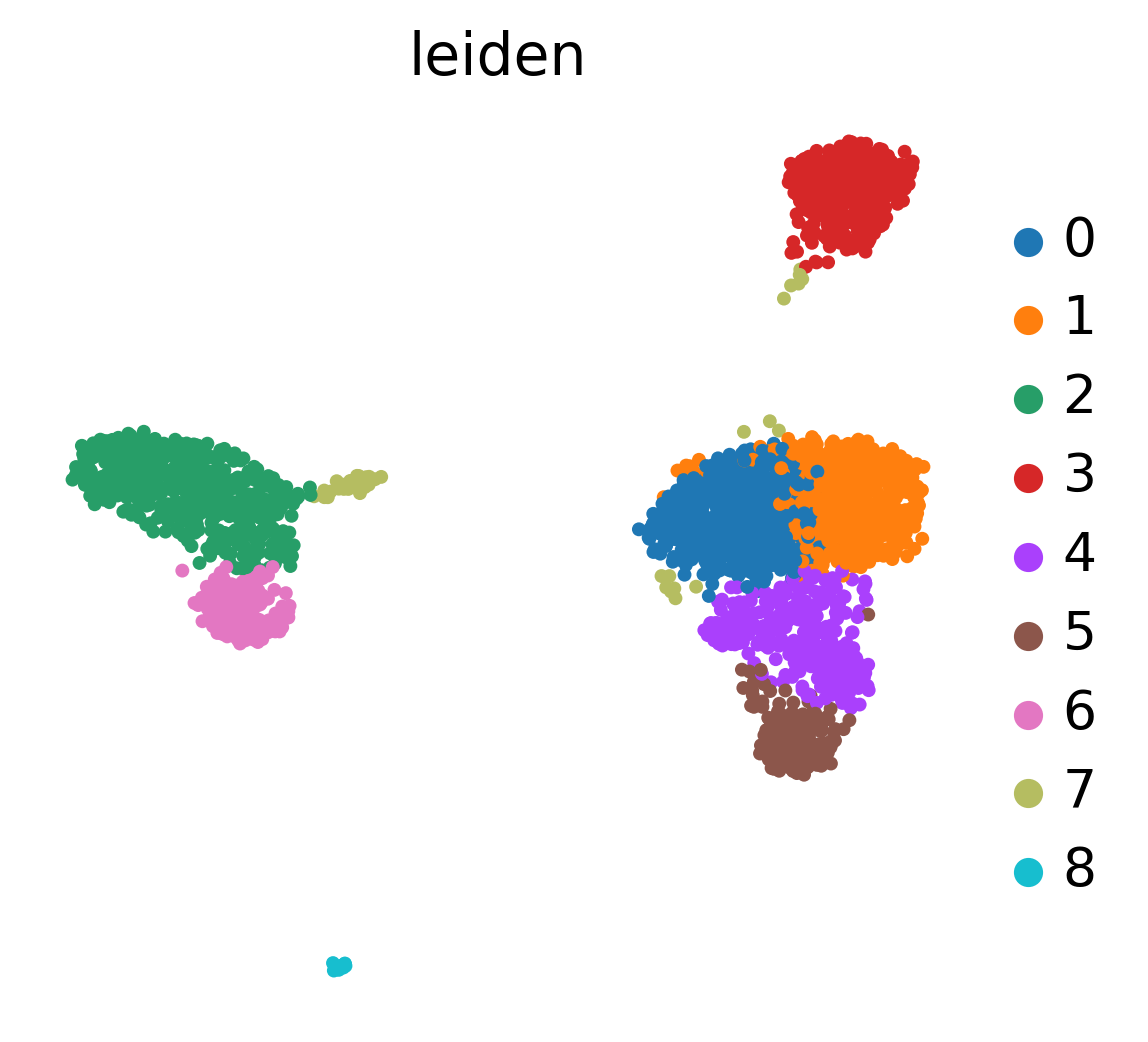

In [ ]:
adata_full = pipeline(adata_full)
sc.pl.umap(adata_full, color="leiden", frameon=False)

По всей видимости, даже это не помогло. Попробуем разобраться &mdash; может, у нас действительно есть разница между этими кластерами?

In [ ]:
sc.tl.rank_genes_groups(adata_full, groupby="leiden", method="wilcoxon", groups=["0"], reference="1")
sc.get.rank_genes_groups_df(adata_full, group="0")[sc.get.rank_genes_groups_df(adata_full, group="0").logfoldchanges > 3].head(10)

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:02)


/usr/local/lib/python3.8/dist-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(


,names,scores,logfoldchanges,pvals,pvals_adj
17,AQP3,6.603027,3.138085,4.028449e-11,6.570198e-08
19,CD52,6.486085,5.464896,8.809524e-11,1.306172e-07
35,CALM1,5.300047,3.485008,1.157727e-07,8.991405e-05
38,GSTK1,5.089056,3.762300,3.598493e-07,2.551723e-04
67,RAN,3.960738,8.120838,7.471845e-05,2.972245e-02
70,MYL12B,3.873584,8.809987,1.072464e-04,4.067757e-02
73,PPP2R5C,3.802429,3.957209,1.432845e-04,5.136039e-02
76,TNFAIP8,3.744797,3.071329,1.805393e-04,6.264907e-02
81,PBXIP1,3.677178,3.177186,2.358286e-04,7.692491e-02
95,GPR183,3.350218,3.559408,8.074813e-04,2.270624e-01


Выглядит так, что нет. Самым разумным решением при дальнейшем анализе будет соединить эти кластера в один более крупный, чтобы в дальнейшем работать с ним как с одним кластером.

## Домашнее задание

Попробуйте сделать функцию-враппер вокруг DESeq2, которая будет работать из-под Python и выполнять дифференциальную экспрессию по матрице каунтов, а также датасету с описанием образцов, которые будут даваться на вход функции. Продумайте, как лучше реализовать хранение аутпута.

Приспособьте эту функцию для scanpy так, чтобы она могла определять дифференциально экспрессированные гены для кластеров, используя их псевдобалки по отдельным образцам. В каком случае имеет смысл использовать эту функцию?

Добработайте функцию на пишите новую функцию на основе `sc.tl.rank_genes_groups()`, чтобы она была аналогом функции <a href="https://satijalab.org/seurat/reference/findconservedmarkers"><code>FindConservedMarkers()</code></a> из Seurat.